In [1]:
import requests
import urllib3
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import time
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import stravalib

import polyline

import folium

pd.set_option("display.max_columns", 100)


Interesting link: https://towardsdatascience.com/using-the-strava-api-and-pandas-to-explore-your-activity-data-d94901d9bfde
Strava API forum: https://groups.google.com/g/strava-api

In [2]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
payload = {
    'client_id': "75483",
    'client_secret': 'd7d1e5483201559ddf62c677ac12f6cf7847c5ae',
    'refresh_token': '75994cf8182a3b6a956390b5a4da3eba764f1d85',
    'grant_type': "refresh_token",
    'f': 'json',
}

In [3]:
print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

Requesting Token...

Access Token = f6ffe089323f6e51647ebb75ae158cdde72c37a0



In [4]:
activites_url = "https://www.strava.com/api/v3/athlete/activities"

dataset=[]
pages_count=1

while pages_count>0:
    header = {'Authorization': 'Bearer ' + access_token}
    param = {'per_page': 200, 'page': pages_count}
    my_dataset=requests.get(activites_url, headers=header, params=param).json()
    if my_dataset==[]:
        break
    elif my_dataset!=[]:
        dataset.append(my_dataset)
        pages_count+=1
dataset = [j for i in dataset for j in i]


In [19]:
activities = pd.json_normalize(dataset)
activities

,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,id,start_date,start_date_local,timezone,utc_offset,location_city,location_state,location_country,achievement_count,kudos_count,comment_count,athlete_count,photo_count,trainer,commute,manual,private,visibility,flagged,gear_id,start_latlng,end_latlng,start_latitude,start_longitude,average_speed,max_speed,average_cadence,has_heartrate,heartrate_opt_out,display_hide_heartrate_option,upload_id,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,workout_type,average_heartrate,max_heartrate,elev_high,elev_low,suffer_score,average_watts,kilojoules,device_watts,average_temp
0,2,Afternoon Swim,1200.0,1537,1716,0.0,Swim,6717059417,2022-02-21T16:50:18Z,2022-02-21T17:50:18Z,(GMT+01:00) Europe/Madrid,3600.0,None,None,None,0,0,0,1,0,True,False,False,True,only_me,False,None,[],[],NaN,NaN,0.781,2.350,26.0,False,False,False,7144000288,7144000288,garmin_push_8335137589,False,0,0,False,30195369,1,a6717059417,None,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Morning Run,15317.5,5022,5056,194.8,Run,6710430932,2022-02-20T09:30:53Z,2022-02-20T10:30:53Z,(GMT+01:00) Europe/Madrid,3600.0,None,None,None,6,12,2,1,0,False,False,False,False,followers_only,False,None,"[40.39397514425218, -3.7626108527183533]","[40.395606849342585, -3.7642173282802105]",40.393975,-3.764217,3.050,4.638,82.5,True,False,True,7136839345,7136839345,garmin_push_8327538243,False,2,0,False,30195369,1,a6710430932,impuFj{}UQs@k@_Ag@kAq@iAIuAJkCGeA?gAg@EiAJg@Gq...,2,0.0,174.4,191.0,694.2,583.7,283.0,NaN,NaN,NaN,NaN
2,2,Afternoon Ride,65758.5,10678,11811,511.4,Ride,6702635727,2022-02-18T15:11:39Z,2022-02-18T16:11:39Z,(GMT+01:00) Europe/Madrid,3600.0,None,None,None,220,0,0,1,0,False,False,False,True,only_me,False,None,"[40.39385033771396, -3.763327756896615]","[40.39401311427355, -3.763417275622487]",40.393850,-3.763417,6.158,12.809,NaN,True,False,True,7128419032,7128419032,garmin_push_8318833595,False,81,0,False,30195369,1,a6702635727,qlpuFx_~U@eE`D}Ev@yPiRqAkGyCcBfC}CUaDnE[tCPfH`...,2,NaN,140.4,184.0,764.6,591.2,140.0,82.9,884.8,False,NaN
3,2,Lunch Run,11008.2,3613,3636,177.4,Run,6696393508,2022-02-17T11:37:37Z,2022-02-17T12:37:37Z,(GMT+01:00) Europe/Madrid,3600.0,None,None,None,3,0,0,1,0,False,False,False,True,only_me,False,None,"[40.3941210731864, -3.762109028175473]","[40.39486471563578, -3.7607221584767103]",40.394121,-3.760722,3.047,4.037,82.4,True,False,True,7121687048,7121687048,garmin_push_8311682621,False,3,0,False,30195369,1,a6696393508,gnpuFdx}USm@[e@GSEWSMUY_@q@CaA?]G{@?m@EaBUCCI]...,2,NaN,156.1,184.0,694.2,630.6,98.0,NaN,NaN,NaN,NaN
4,2,Morning Run,9889.6,5151,6060,615.5,Run,6676049673,2022-02-13T08:40:59Z,2022-02-13T09:40:59Z,(GMT+01:00) Europe/Madrid,3600.0,None,None,None,4,10,0,2,0,False,False,False,False,followers_only,False,None,"[42.26483873091638, 2.742780586704612]","[42.266018483787775, 2.7470195665955544]",42.264839,2.747020,1.920,3.715,79.2,True,False,True,7099787429,7099787429,garmin_push_8288403170,False,3,0,False,30195369,1,a6676049673,ez}`GkuvOBp@V~@Lh@b@|@~@bA~@l@vArBZCd@NFQAw@Pq...,2,0.0,165.3,193.0,1093.8,417.4,210.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,2,Ciclismo al anochecer,47446.6,7447,7632,295.5,Ride,1578340888,2018-05-17T16:01:00Z,2018-05-17T18:01:00Z,(GMT+01:00) Europe/Madrid,7200.0,None,None,None,38,0,0,1,0,False,False,False,False,followers_only,False,None,"[42.248587, 2.958732]","[42.248741, 2.958242]",42.248587,2.958242,6.371,13.400,NaN,False,False,False,1696975141,1696975141,f5514f296dc4626b4a6dc25b51f5d0e5,False,9,0,False,30195369,1,a1578340888,qzz`Gat}Pk@nEHnC~ATn@x@rArDg@xB`DxDvA~@nFm@hFn...,2,10.0,NaN,NaN,123.0,0.9,NaN,NaN,NaN,False,

In [21]:
#Create new dataframe with only columns I care about
cols =['name',
          'start_date_local',
          'id',
          'type',
          'distance',
          'moving_time',
          'elapsed_time',
          'total_elevation_gain',
          'elev_high',
          'elev_low',
          'average_speed',
          'max_speed',
          'average_heartrate',
          'max_heartrate',
          'start_latitude',
          'start_longitude',
          'map.summary_polyline']

activities = activities[cols]
"""
# Convert dates to datetime type
activities['start_date_local']= [datetime.strptime(i,"%Y-%m-%dT%H:%M:%SZ") for i in activities['start_date_local']]
activities['start_time']=[time(hour=i.hour,minute=i.minute,second=i.second) for i in activities['start_date_local']]
activities['start_date_local'] =[date(year=i.year,month=i.month,day=i.day) for i in activities['start_date_local']]
"""
# Create a distance in km column
activities['distance_km'] = activities['distance']/1000

# Convert dates to datetime type
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])

# Create a day of the week and month of the year columns
activities['day_of_week'] = activities['start_date_local'].dt.day_name()
activities['month_of_year'] = activities['start_date_local'].dt.month
# Convert times to timedeltas
activities['moving_time'] = pd.to_timedelta(activities['moving_time'])
activities['elapsed_time'] = pd.to_timedelta(activities['elapsed_time'])
# Convert timings to hours for plotting
activities['elapsed_time_hr'] = activities['elapsed_time'].view(int)/3600
activities['moving_time_hr'] = activities['moving_time'].view(int)/3600

activities.head()

,name,start_date_local,id,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_speed,max_speed,average_heartrate,max_heartrate,start_latitude,start_longitude,map.summary_polyline,distance_km,day_of_week,month_of_year,elapsed_time_hr,moving_time_hr
0,Afternoon Swim,2022-02-21 17:50:18+00:00,6717059417,Swim,1200.0,0 days 00:00:00.000001537,0 days 00:00:00.000001716,0.0,NaN,NaN,0.781,2.350,NaN,NaN,NaN,NaN,None,1.2000,Monday,2,0.476667,0.426944
1,Morning Run,2022-02-20 10:30:53+00:00,6710430932,Run,15317.5,0 days 00:00:00.000005022,0 days 00:00:00.000005056,194.8,694.2,583.7,3.050,4.638,174.4,191.0,40.393975,-3.764217,impuFj{}UQs@k@_Ag@kAq@iAIuAJkCGeA?gAg@EiAJg@Gq...,15.3175,Sunday,2,1.404444,1.395000
2,Afternoon Ride,2022-02-18 16:11:39+00:00,6702635727,Ride,65758.5,0 days 00:00:00.000010678,0 days 00:00:00.000011811,511.4,764.6,591.2,6.158,12.809,140.4,184.0,40.393850,-3.763417,qlpuFx_~U@eE`D}Ev@yPiRqAkGyCcBfC}CUaDnE[tCPfH`...,65.7585,Friday,2,3.280833,2.966111
3,Lunch Run,2022-02-17 12:37:37+00:00,6696393508,Run,11008.2,0 days 00:00:00.000003613,0 days 00:00:00.000003636,177.4,694.2,630.6,3.047,4.037,156.1,184.0,40.394121,-3.760722,gnpuFdx}USm@[e@GSEWSMUY_@q@CaA?]G{@?m@EaBUCCI]...,11.0082,Thursday,2,1.010000,1.003611
4,Morning Run,2022-02-13 09:40:59+00:00,6676049673,Run,9889.6,0 days 00:00:00.000005151,0 days 00:00:00.000006060,615.5,1093.8,417.4,1.920,3.715,165.3,193.0,42.264839,2.747020,ez}`GkuvOBp@V~@Lh@b@|@~@bA~@l@vArBZCd@NFQAw@Pq...,9.8896,Sunday,2,1.683333,1.430833


In [30]:
activities['type'].value_counts()


Ride              171
Run               126
Swim               85
Hike               50
Workout             2
BackcountrySki      1
Name: type, dtype: int64

In [31]:
activities.isnull().sum()

name                      0
start_date_local          0
id                        0
type                      0
distance                  0
moving_time               0
elapsed_time              0
total_elevation_gain      0
elev_high                77
elev_low                 77
average_speed             0
max_speed                 0
average_heartrate       100
max_heartrate           100
start_latitude           80
start_longitude          80
map.summary_polyline     80
distance_km               0
day_of_week               0
month_of_year             0
elapsed_time_hr           0
moving_time_hr            0
dtype: int64

In [38]:
runs = activities.loc[activities['type'] == 'Run']
runs['average_pace_sec']=(runs['moving_time'])/(runs['distance']/1000)
runs['average_speed']=runs['average_speed']*3600/1000
runs['max_speed']=runs['max_speed']*3600/1000
runs['average_pace']=pd.to_timedelta(runs['average_pace_sec'], unit='s')
runs['distance']=runs['distance']/1000
runs.head(5)


/Users/ivan.repilado/miniconda3/envs/ironhack/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ivan.repilado/miniconda3/envs/ironhack/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ivan.repilado/miniconda3/envs/ironhack/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying

,name,start_date_local,id,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_speed,max_speed,average_heartrate,max_heartrate,start_latitude,start_longitude,map.summary_polyline,distance_km,day_of_week,month_of_year,elapsed_time_hr,moving_time_hr,average_pace_sec,average_pace
1,Morning Run,2022-02-20 10:30:53+00:00,6710430932,Run,15.3175,0 days 00:00:00.000005022,0 days 00:00:00.000005056,194.8,694.2,583.7,10.9800,16.6968,174.4,191.0,40.393975,-3.764217,impuFj{}UQs@k@_Ag@kAq@iAIuAJkCGeA?gAg@EiAJg@Gq...,15.3175,Sunday,2,1.404444,1.395000,0 days 00:00:00.000000327,0 days 00:00:00.000000327
3,Lunch Run,2022-02-17 12:37:37+00:00,6696393508,Run,11.0082,0 days 00:00:00.000003613,0 days 00:00:00.000003636,177.4,694.2,630.6,10.9692,14.5332,156.1,184.0,40.394121,-3.760722,gnpuFdx}USm@[e@GSEWSMUY_@q@CaA?]G{@?m@EaBUCCI]...,11.0082,Thursday,2,1.010000,1.003611,0 days 00:00:00.000000328,0 days 00:00:00.000000328
4,Morning Run,2022-02-13 09:40:59+00:00,6676049673,Run,9.8896,0 days 00:00:00.000005151,0 days 00:00:00.000006060,615.5,1093.8,417.4,6.9120,13.3740,165.3,193.0,42.264839,2.747020,ez}`GkuvOBp@V~@Lh@b@|@~@bA~@l@vArBZCd@NFQAw@Pq...,9.8896,Sunday,2,1.683333,1.430833,0 days 00:00:00.000000520,0 days 00:00:00.000000520
6,Afternoon Run,2022-02-09 17:12:44+00:00,6656698791,Run,8.0019,0 days 00:00:00.000002563,0 days 00:00:00.000002611,143.5,668.5,640.4,11.2392,17.1108,153.2,190.0,40.394094,-3.762571,anpuFzz}UXo@n@q@l@g@^a@Vk@H]B]VyAD]?mADYBEl@a@...,8.0019,Wednesday,2,0.725278,0.711944,0 days 00:00:00.000000320,0 days 00:00:00.000000320
7,Afternoon Run,2022-02-07 17:35:18+00:00,6646079714,Run,11.0114,0 days 00:00:00.000003331,0 days 00:00:00.000003389,91.8,668.7,600.9,11.9016,15.2748,156.9,180.0,40.393794,-3.764696,elpuFlx}Ua@e@u@iAe@a@[i@G_@@{@Ic@@]Ec@HcCMw@{@...,11.0114,Monday,2,0.941389,0.925278,0 days 00:00:00.000000302,0 days 00:00:00.000000302


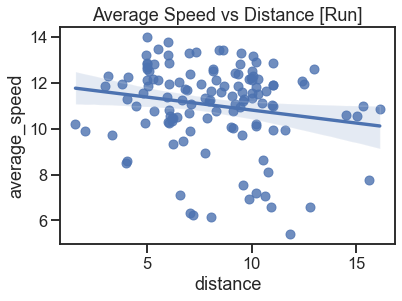

In [39]:
sns.set(style="ticks", context="talk")
sns.regplot(x='distance', y = 'average_speed', data = runs).set_title("Average Speed vs Distance [Run]");
#Units are km per hour!

array([<AxesSubplot:xlabel='start_date_local'>,
       <AxesSubplot:xlabel='start_date_local'>,
       <AxesSubplot:xlabel='start_date_local'>,
       <AxesSubplot:xlabel='start_date_local'>], dtype=object)

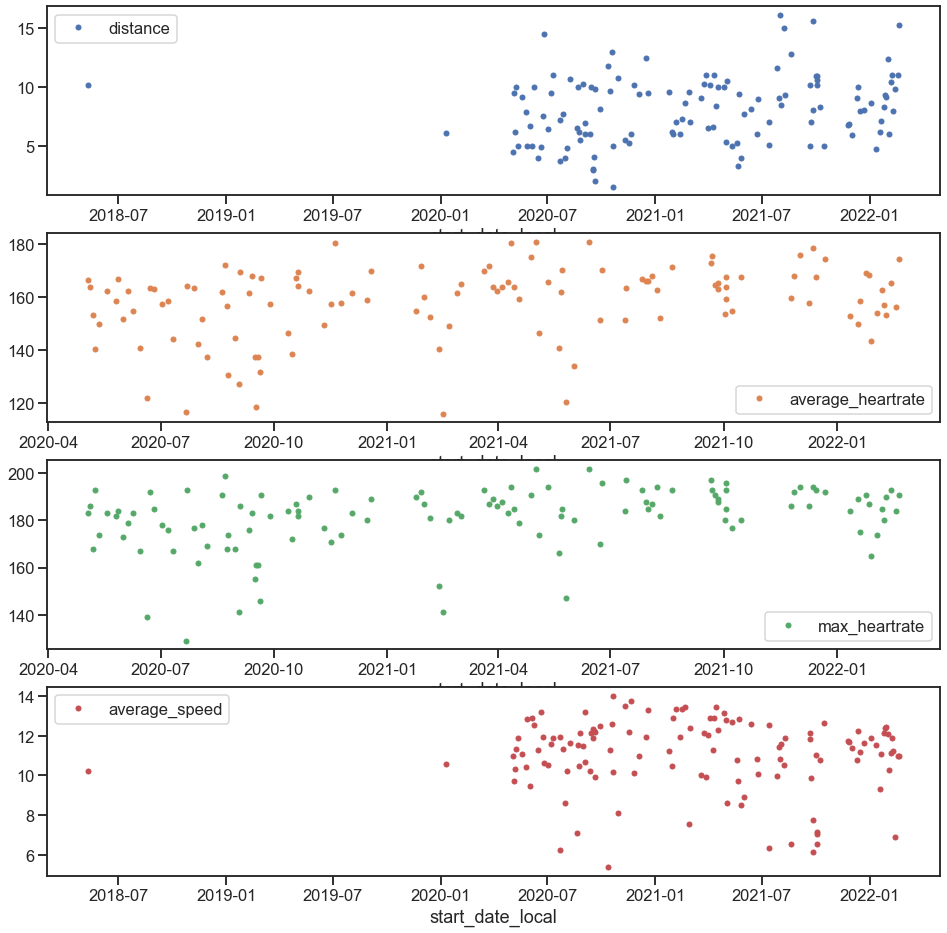

In [36]:
runs.plot(x='start_date_local' ,y=['distance','average_heartrate','max_heartrate','average_speed'],subplots=True,
                           sharex=False,
                           figsize=(16,16),
                           linestyle='none',
                           marker='o',
                           markersize=5,
                          )

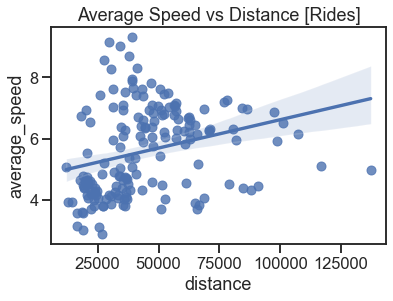

In [9]:
rides = activities.loc[activities['type'] == 'Ride']
sns.set(style="ticks", context="talk")
sns.regplot(x='distance', y = 'average_speed', data = rides).set_title("Average Speed vs Distance [Rides]");


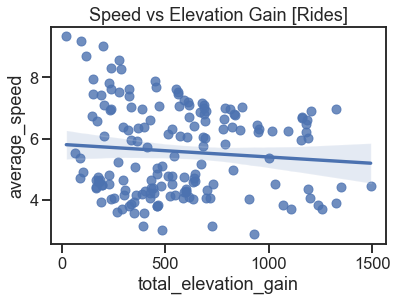

In [10]:
rides_filtered = rides.loc[(rides['total_elevation_gain'] < 1500)]
sns.regplot(x='total_elevation_gain', y = 'average_speed', data = rides_filtered).set_title("Speed vs Elevation Gain [Rides]");


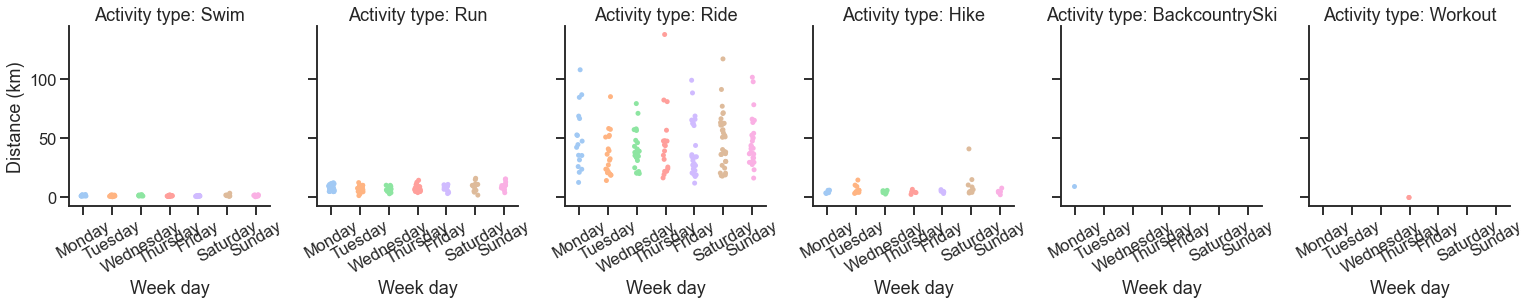

In [11]:
day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]
g = sns.catplot(x='day_of_week', y='distance_km', kind='strip', data=activities, order=day_of_week_order, col='type', height=4, aspect=0.9, palette='pastel')
(g.set_axis_labels("Week day", "Distance (km)")
  .set_titles("Activity type: {col_name}")
  .set_xticklabels(rotation=30));

In [28]:
#Activity number we want to plot in the map
activity_number=1

latlon=polyline.decode(activities['map.summary_polyline'][activity_number])

In [23]:
mapit = None
for coord in latlon:
    mapit = folium.Map( location=[ coord[0], coord[1] ] )

folium.PolyLine(latlon,
                color='red',
                weight=3,
                opacity=0.8).add_to(mapit)

mapit.save( 'map.html')

mapit

### Get the maps of the routes
https://developers.google.com/maps/documentation/utilities/polylineutility